# Battle of Neighborhoods Toronto and Paris

## 1. Introduction

Toronto and Paris are best cities in the world for tourists as well as business purposes. The cities are most happening cities in the world
Both cities has diverse cultures as well as communities. We will try to examine the neighbourhoods in Toronto and Paris that will help the visisotr 
provide insights for toursim selection or business destination

## 2. Business Problem

The aim is to help tourists choose their destinations depending on the experiences that the neighbourhoods have to offer and
what they would want to have. This also helps people make decisions if they are thinking about migrating to Toronto or Paris 
or even if they want to relocate neighbourhoods within the city. Our findings will help stakeholders make informed decisions
and address any concerns they have including the different kinds of cuisines, provision stores and what the city has to offer

## 3. Data Description

We require geolocation data for both Toronto and Paris. Postal codes in each city serve as a starting point. Using Postal codes we use can find out the neighbourhoods, boroughs, venues and their most popular 
venue categories

### 3.1 Toronto

To derive our solution, We scrape our data from "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

This wikipedia page has information about all the neighbourhoods, we limit it Toronto

borough : Name of Neighbourhood
town : Name of borough
post_code : Postal codes for Toronto.


### 3.2 Paris

To derive our solution, We leverage JSON data available at https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e

The JSON file has data about all the neighbourhoods in France, we limit it to Paris.

postal_code : Postal codes for France
nom_comm : Name of Neighbourhoods in France
nom_dept : Name of the boroughs, equivalent to towns in France
geo_point_2d : Tuple containing the latitude and longitude of the Neighbourhoods.

### 3.3 Foursquare API data

We will need data about different venues in different neighbourhoods of that specific borough. In order to gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighbourhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighbourhood. For each neighbourhood, we have chosen the radius to be 500 meters.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

Neighbourhood : Name of the Neighbourhood <br>
Neighbourhood Latitude : Latitude of the Neighbourhood <br>
Neighbourhood Longitude : Longitude of the Neighbourhood <br>
Venue : Name of the Venue <br>
Venue Latitude : Latitude of Venue <br>
Venue Longitude : Longitude of Venue <br>
Venue Category : Category of Venue <br>
Based on all the information collected for both Toronto and Paris, we have sufficient data to build our model. We cluster the neighbourhoods together based on similar venue categories. We then present our observations and findings. Using this data, our stakeholders can take the necessary decision.

# 4. Methodology

Python will be used for this project with the help of several packages and libraries

import pandas as pd <br>
import requests <br>
import numpy as np <br>
import matplotlib.cm as cm <br>
import matplotlib.colors as colors <br>
import folium
from sklearn.cluster import KMeans  <br>
import json <br>
from geopy.geocoders import Nominatim

## 4.1 Data Acquisition

In the data collection stage, we begin with collecting the required data for the cities of Toronto and Paris. We need data that has the postal codes, neighbourhoods and boroughs specific to each of the cities

Toronto collection:

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" <br>
wiki = requests.get(url) <br>
wiki_data = pd.read_html(wiki.text) <br>
wiki_data.head() <br>

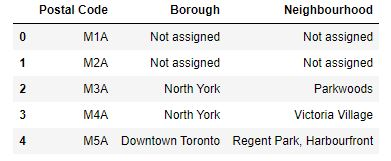

Paris Data collection

!wget -q -O 'france-data.json' https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e <br>
print("Data Downloaded!")
paris_raw = pd.read_json('france-data.json')
paris_raw.head()

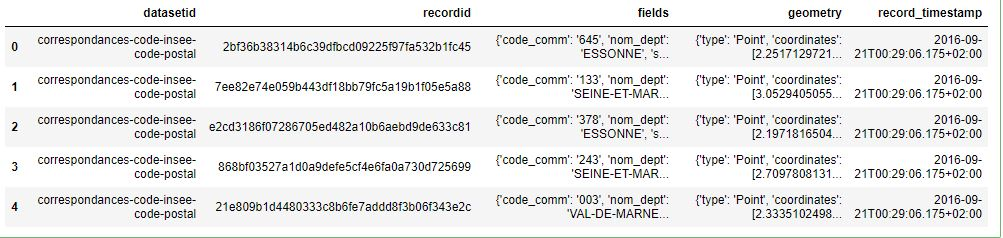

## 4.2 Data Processing

For Toronto we will remove not assinged, group the postal codes and re-index the records

df = wiki_data[wiki_data["Borough"] !='Not assigned'] <br>
df = df.groupby(['Postal Code']).head() <br>
df=df.reset_index() <br>
df.drop(['index'], axis = 'columns', inplace = True) <br>

For Paris, we break down each of the nested fields and create the dataframe that we need:

paris_field_data = pd.DataFrame() <br>
for f in paris_raw.fields: <br>
    dict_new = f <br>
    paris_field_data = paris_field_data.append(dict_new, ignore_index=True) <br>

paris_field_data.head() <br>

## 4.3 Feature Selection

For both of our datasets, we need only the borough, neighbourhood, postal codes and geolocations (latitude and longitude).
So we end up selecting the columns that we need.

## 4.4 Feature Engineering

Both of our Datasets actually contain information related to all the cities in the country. We can narrow down and further process the data by selecting only the neighbourhoods pertaining to 'Toronto' and 'Paris'

For Toronto dataset
Geo_data=pd.read_csv("http://cocl.us/Geospatial_data") <br>
df_loc = df.join(Geo_data.set_index('Postal Code'), on='Postal Code' , how='inner')

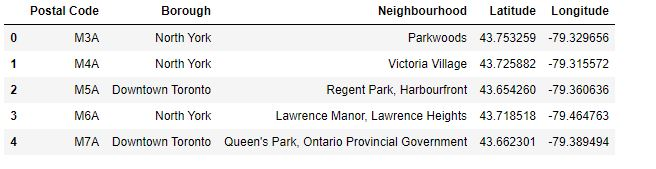

As for our Paris dataset, we don't need to get the geo coordinates using an external data source or collect it with the ArcGIS API call since we already have it stored in the geo_point_2d column as a tuple in the df_paris dataframe.

We just need to extract the latitude and longitude for the column: <br>

paris_lat = paris_latlng.apply(lambda x: x.split(',')[0]) <br>
paris_lat = paris_lat.apply(lambda x: x.lstrip('[')) <br>

paris_lng = paris_latlng.apply(lambda x: x.split(',')[1]) <br>
paris_lng = paris_lng.apply(lambda x: x.rstrip(']')) <br>

paris_geo_lat  = pd.DataFrame(paris_lat.astype(float)) <br>
paris_geo_lat.columns=['Latitude'] <br>

paris_geo_lng = pd.DataFrame(paris_lng.astype(float)) <br>
paris_geo_lng.columns=['Longitude'] <br>
We then create our Paris dataset with the required information: <br>

paris_combined_data = pd.concat([df_paris.drop('geo_point_2d', axis=1), paris_geo_lat, paris_geo_lng], axis=1) <br>
paris_combined_data

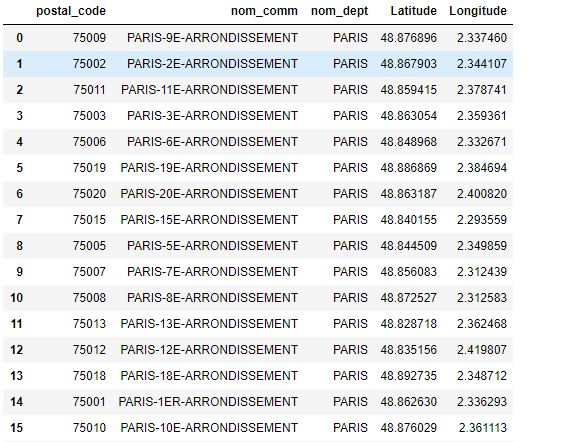

## 4.5 Visualizing the Neighbourhoods of Toronto and Paris

Neighbourhoold map of Toronto

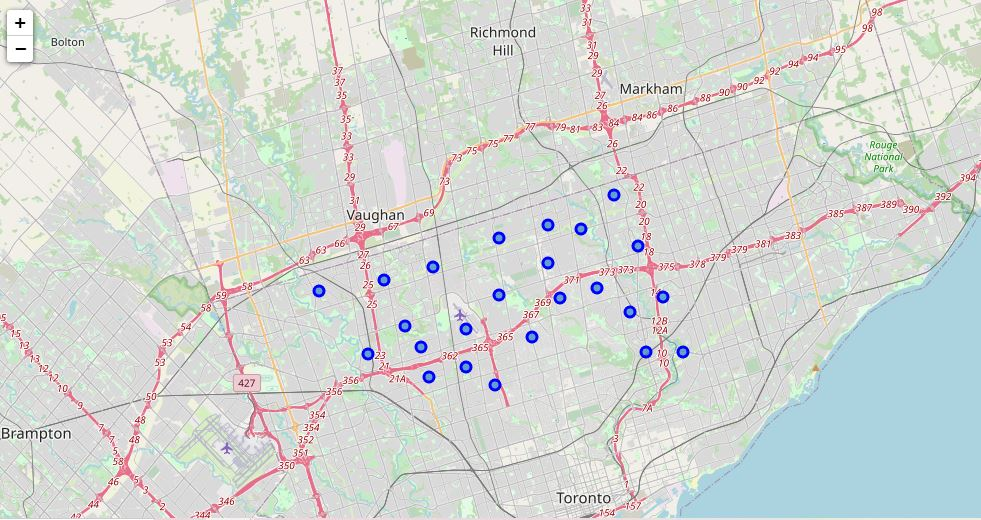

Neighbourhood map of Paris

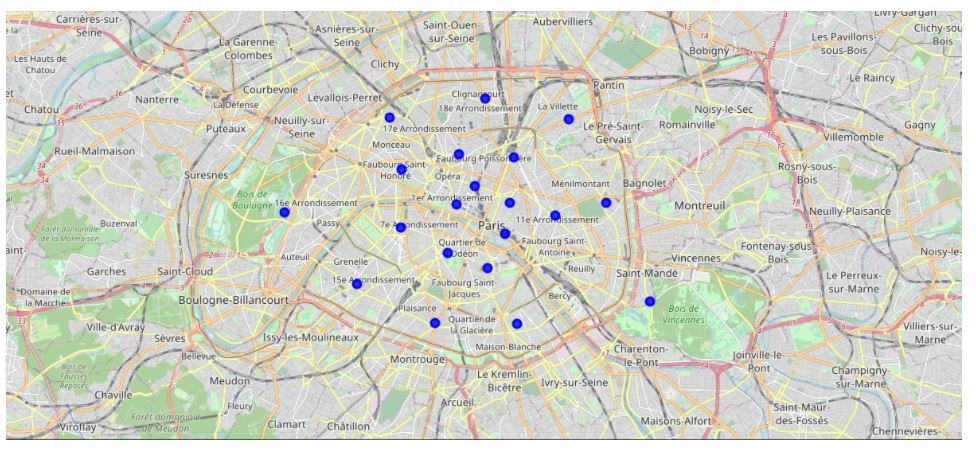

Now that we have visualized the neighbourhoods, we need to find out what each neighbourhood is like and what are the common venue and venue categories within a 500m radius. <br>

This is where Foursquare comes into play. With the help of Foursquare we define a function which collects information pertaining to each neighbourhood including that of the name of the neighbourhood, geo-coordinates, venue and venue categorie


def getNearbyVenues(names, latitudes, longitudes, radius=500): <br>
    
    venues_list=[] <br>
    for name, lat, lng in zip(names, latitudes, longitudes):<br>
        print(name) <br>
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format <br>
            CLIENT_ID,  <br>
            CLIENT_SECRET, <br>
            VERSION, <br>
            lat, <br>
            lng, <br>
            radius, <br>
            LIMIT)<br>
            
        # make the GET request<br>
        results = requests.get(url).json()["response"]['groups'][0]['items']<br>
        venues_list.append([(<br>
            name, <br>
            lat, <br>
            lng, <br>
            v['venue']['name'], <br>
            v['venue']['location']['lat'], <br>
            v['venue']['location']['lng'], <br> 
            v['venue']['categories'][0]['name']) for v in results])<br>

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])<br>
    nearby_venues.columns = ['Neighbourhood', <br>
                  'Neighborhood Latitude', <br>
                  'Neighborhood Longitude', <br>
                  'Venue', <br>
                  'Venue Latitude', <br>
                  'Venue Longitude', <br>
                  'Venue Category']<br>
    
    return(nearby_venues)<br>

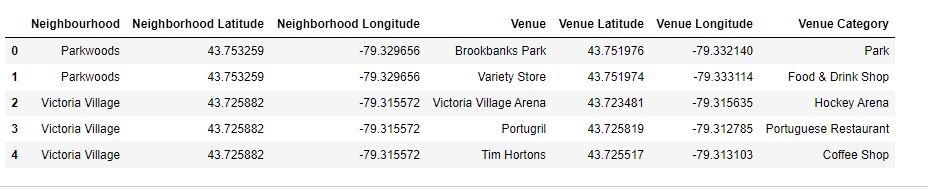

## 4.6 Top venues

In our next step, We need to rank and label the top venue categories in our neighborhood

num_top_venues = 10 

indicators = ['st', 'nd', 'rd']


columns = ['Neighbourhood']  <br>
for ind in np.arange(num_top_venues):<br>
    try: <br>
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) <br>
    except:<br>
        columns.append('{}th Most Common Venue'.format(ind+1)) <br>


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)<br>
neighborhoods_venues_sorted['Neighbourhood'] = NY_grouped['Neighbourhood'] <br>

for ind in np.arange(NY_grouped.shape[0]):<br>
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues) <br>

neighborhoods_venues_sorted.head()

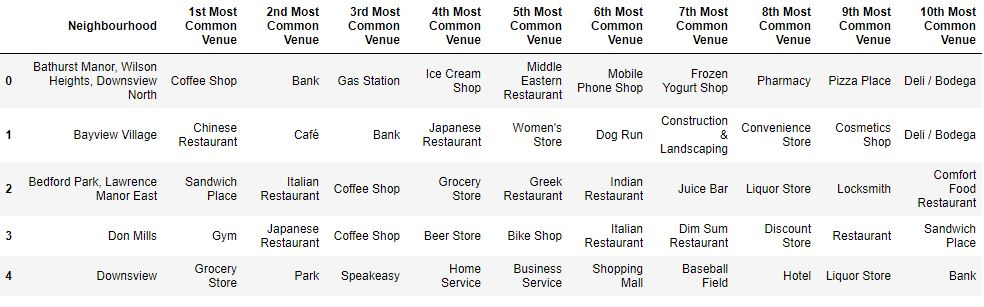

## 4.7 Model Building - KMeans


Moving on to the most exicitng part - Model Building! We will be using KMeans Clustering Machine learning algorithm to cluster similar neighbourhoods together. We will be going with the number of clusters as 5.

#### set number of clusters
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighbourhood', 1)

#### run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

#### check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) <br>
NY_merged = df_NY_data

####  add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood') <br>
NY_merged['Cluster Labels'].isna().sum()

NY_merged.head() # check the last columns!

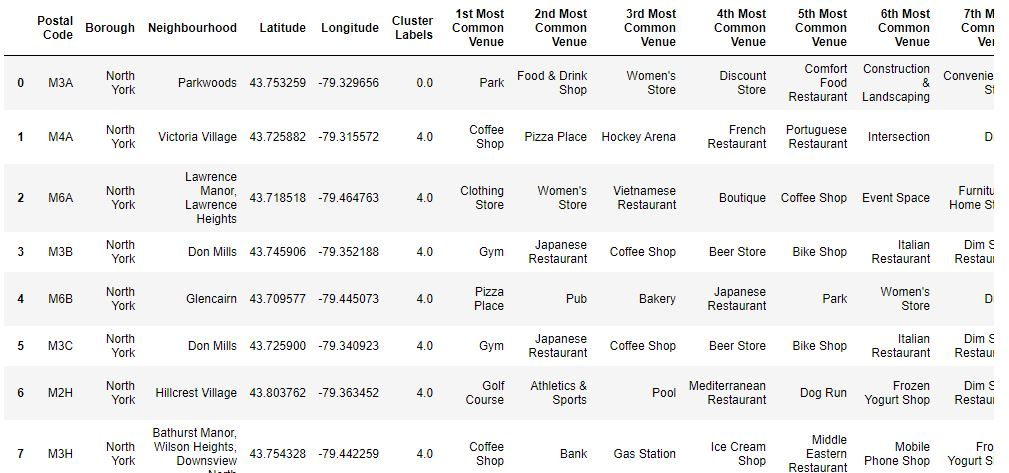

## 4.8 Visualizing the Clustered Neighbourhoods in Toronto and Paris

Our data is processed, missing data is collected and compiled. The Model is built. All that's remaining is to see the clustered neighbourhoods on the map. Again, we use Folium package to do so.

Toronto - Clustered Neighborhood

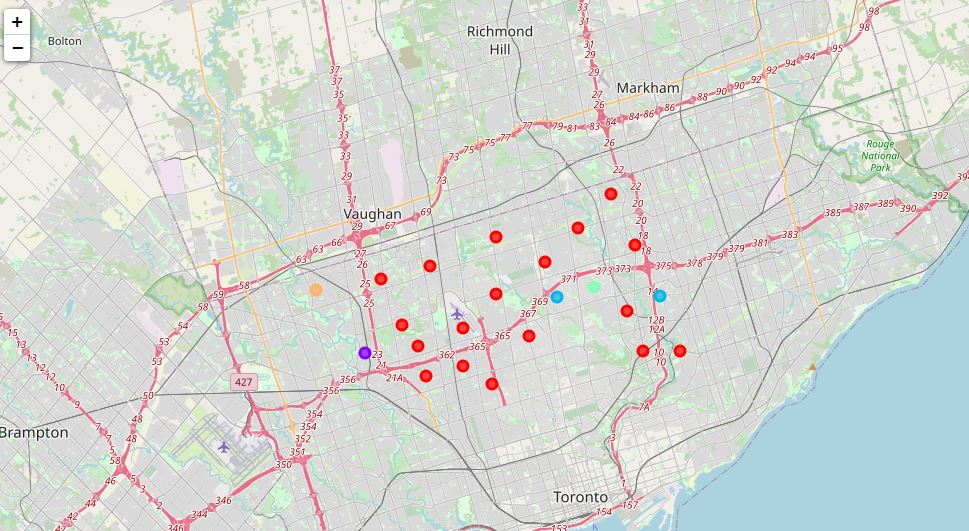

Paris - Clustered Neighborhood

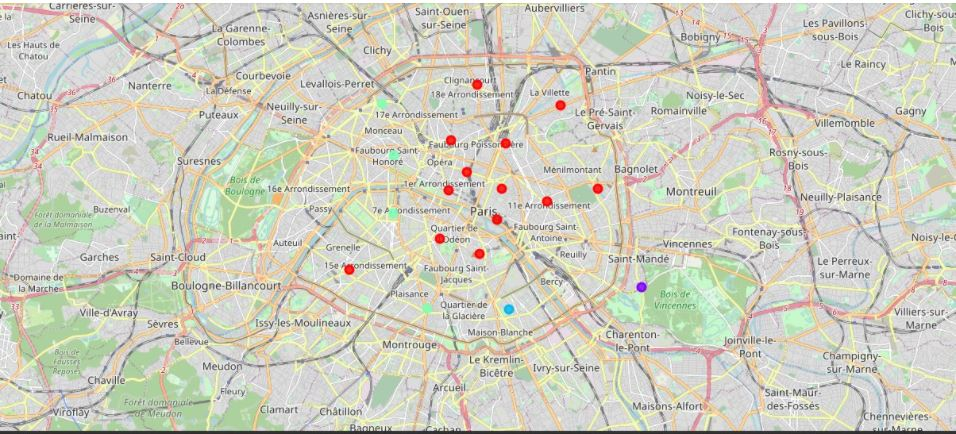

### 4.9.1 Examining Clusters

We could examine our clusters by expanding on our code using the Cluster Labels column

#### Toronto - Clusters

Cluster 1 <br>
NY_merged.loc[NY_merged['Cluster Labels'] == 0, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

Cluster 2 <br>
NY_merged.loc[NY_merged['Cluster Labels'] == 1, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

Cluster 3 <br>
NY_merged.loc[NY_merged['Cluster Labels'] == 2, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

Cluster 4 <br>
NY_merged.loc[NY_merged['Cluster Labels'] == 3, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

Cluster 5 <br>
NY_merged.loc[NY_merged['Cluster Labels'] == 4, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

##### Paris - Clusers


Cluster 1

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 1, paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

Cluster 2

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 2, paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

Cluster 3

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 3, paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

Cluster 4

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 4, paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

Cluster 5

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 5, paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

## 5. Results and Discussion

The neighbourhoods of Toronto are very mulitcultural. There are a lot of different cusines including Indian, Italian, Turkish 
and Chinese. London seems to take a step further in this direction by having a lot of Restaurants, bars, juice bars, coffee 
shops, Fish and Chips shop and Breakfast spots. It has a lot of shopping options too with that of the Flea markets, flower
shops, fish markets, Fishing stores, clothing stores. The main modes of transport seem to be Buses and trains. For leisure, 
the neighbourhoods are set up to have lots of parks, golf courses, zoo, gyms and Historic sites. Overall, the city of Toronto
offers a multicultural, diverse and certainly an entertaining experience.

Paris is relatively small in size geographically. It has a wide variety of cusines and eateries including French, Thai, 
Cambodian, Asian, Chinese etc. There are a lot of hangout spots including many Restaurants and Bars. Paris has a lot of
Bistro's. Different means of public transport in Paris which includes buses, bikes, boats or ferries. For leisure and 
sight seeing, there are a lot of Plazas, Trails, Parks, Historic sites, clothing shops, Art galleries and Museums. 
Overall, Paris seems like the relaxing vacation spot with a mix of lakes, historic spots and a wide variety of cusines
to try out.

## 6. Conclusion

The purpose of this project was to explore the cities of Toronto and Paris and see how attractive it is to potential tourists
and migrants. We explored both the cities based on their postal codes and then extrapolated the common venues present in each 
of the neighbourhoods finally concluding with clustering similar neighbourhoods together.

We could see that each of the neighbourhoods in both the cities have a wide variety of experiences to offer which is unique 
in it's own way. The cultural diversity is quite evident which also gives the feeling of a sense of inclusion.

Both Paris and Toronto seem to offer a vacation stay or a romantic getaway with a lot of places to explore, beautiful landscapes, amazing food and a wide variety of culture. Overall, it's upto the stakeholders to decide which experience they would prefer more and which would more to their liking.

The detailed code is available on GitHub

https://github.com/Nagaraju10/Coursera_Capstone/blob/master/Battles%20of%20Neighborhoods%20Toronto%20and%20Paris.ipynb

## 7. References

https://www.arcgis.com/index.html

https://foursquare.com/
